In [76]:
import jax
import numpy as np
import numpyro
import blackjax
import optuna
import arviz as az
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam

rng_key = jax.random.PRNGKey(1) 

In [2]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, infos

In [3]:
def inference(model):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000)
    mcmc.warmup(rng_key, extra_fields=('num_steps',))
    warmup_steps = mcmc.get_extra_fields()['num_steps']
    mcmc.run(rng_key, extra_fields=('num_steps',))
    mcmc_step = mcmc.get_extra_fields()['num_steps']
    # mcmc.print_summary(exclude_deterministic=False)
    return mcmc.get_samples(), mcmc_step + warmup_steps

In [4]:
def scatterplt(samples):
    fig, axes = plt.subplots(5, 2, figsize=(10, 12))
    axes = axes.flatten()
    samples_theta = samples['theta_decentered'].T
    for i in range(10):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'x_{i}')
        axes[i].set_ylabel('log_std')

In [5]:
d = 500  # Specify the desired length
true_centeredness = jax.random.uniform(rng_key, shape=(d,))
print(true_centeredness)

[0.64137816 0.6430788  0.90541947 0.37226582 0.29733372 0.89236724
 0.4675448  0.6395303  0.6138365  0.8114306  0.2258277  0.89734507
 0.9302367  0.74208593 0.15441573 0.33330297 0.6456387  0.7120445
 0.59421694 0.34617937 0.36394334 0.15190697 0.01602316 0.13050127
 0.4683143  0.43763292 0.14794314 0.14615345 0.29820836 0.11111057
 0.10791945 0.0672859  0.0651927  0.8280891  0.558691   0.22532809
 0.7238573  0.54892266 0.6229814  0.6905947  0.35092366 0.6058047
 0.31139803 0.5241544  0.05914915 0.00913692 0.59864676 0.15959859
 0.7304441  0.9449663  0.5021248  0.8921453  0.4767959  0.577284
 0.47263992 0.8429402  0.1479528  0.34526098 0.18460596 0.20569253
 0.7602532  0.29538    0.5278425  0.47906697 0.56970537 0.30058205
 0.64482    0.16127563 0.15073216 0.48326004 0.5934535  0.18519926
 0.8054731  0.96725917 0.12265778 0.33196807 0.68864167 0.41405344
 0.7666738  0.30162823 0.6678903  0.7446307  0.9189198  0.25101614
 0.26158977 0.33023667 0.66778743 0.14510572 0.51350236 0.5263046


In [6]:
def ll_pdf(centeredness, J, tau, mu, theta):
    return dist.Normal(jnp.full(J,mu*(1-centeredness)), jnp.exp(tau*(1-centeredness))).log_prob(theta) - dist.Normal(jnp.full(J,mu), jnp.exp(tau)).log_prob(theta)

In [7]:
def funnel(J=d, c = true_centeredness):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Normal(0,1))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), jnp.exp(tau)))
    numpyro.factor('theta_ll', ll_pdf(c, J, tau, mu, theta))

In [8]:
num_warmup = 1000

adapt = blackjax.window_adaptation(blackjax.nuts, funnel)
key = jax.random.PRNGKey(0)
(last_state, parameters), intermediate_states,logdensity_fn, calculated_centeredness, num_warmup_steps  = adapt.run(key, num_warmup)
kernel = blackjax.nuts(logdensity_fn , **parameters).step

In [39]:
grad_evals_nlr_warmup = sum(num_warmup_steps)

In [11]:
calculated_centeredness = np.array(calculated_centeredness)

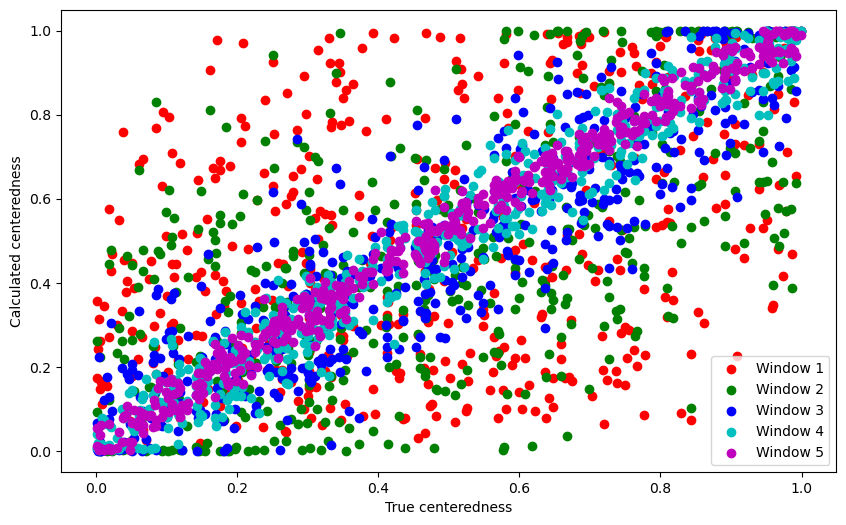

In [12]:
colors = ['r', 'g', 'b', 'c', 'm']  # You can customize the colors as desired

# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for i in range(5):
    plt.scatter(true_centeredness, calculated_centeredness[i], color=colors[i], label=f'Window {i+1}')

# Add labels and legend
plt.xlabel('True centeredness')
plt.ylabel('Calculated centeredness')
plt.legend()


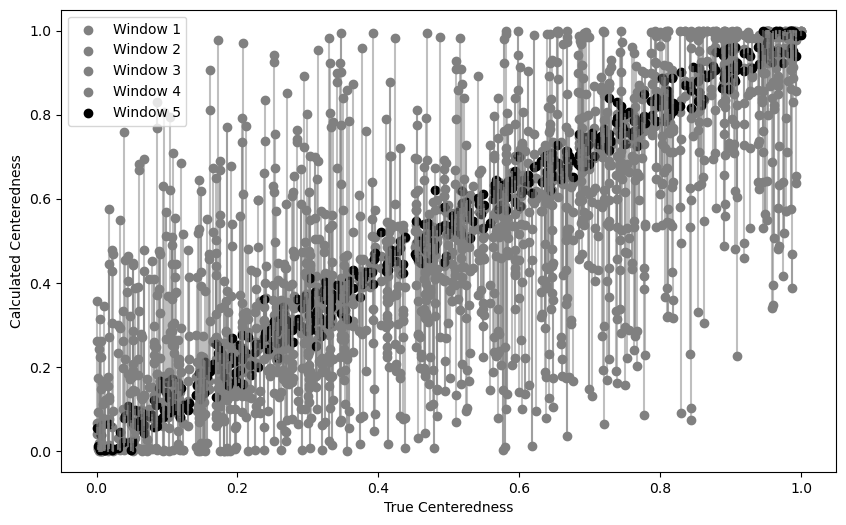

In [78]:
# Define colors for each point in the (5,500) shaped array
colors = ['grey', 'grey', 'grey', 'grey', 'k']  # You can customize the colors as desired

# Create the scatter plot with connecting lines
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for i in range(5):
    for j in range(1, 500):
        plt.plot(calculated_centeredness[i, j-1], calculated_centeredness[i, j], color=colors[i], alpha = 1)
        if i > 0:
            plt.plot([true_centeredness[j], true_centeredness[j]],
                     [calculated_centeredness[i-1, j], calculated_centeredness[i, j]], color='grey', alpha = 0.5)

for i in range(5):
    plt.scatter(true_centeredness, calculated_centeredness[i], color=colors[i], label=f'Window {i+1}')

# Add labels and legend
plt.xlabel('True Centeredness')
plt.ylabel('Calculated Centeredness')
plt.legend()

# Show the plot
plt.show()


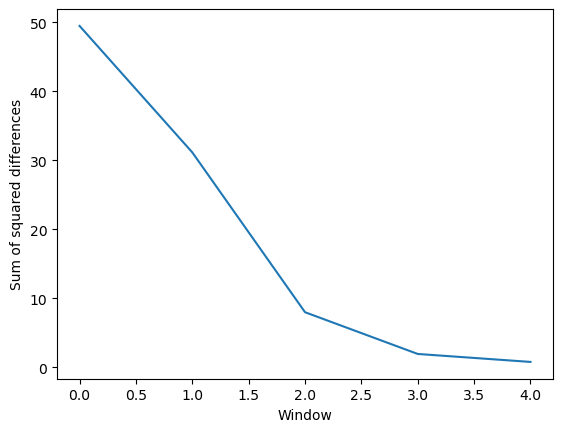

In [14]:
diff = calculated_centeredness - true_centeredness
sum_of_squares = np.sum(diff**2, axis=1)
plt.xlabel('Window')
plt.ylabel('Sum of squared differences')
plt.plot(sum_of_squares)

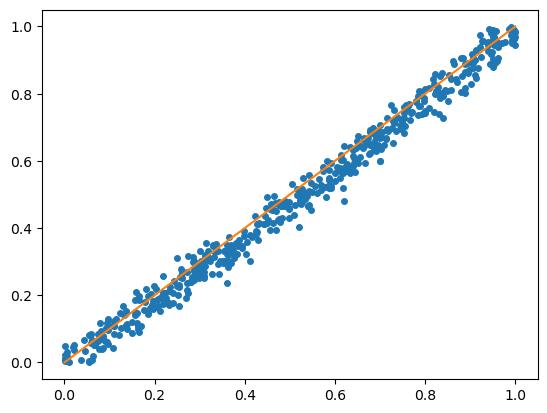

In [15]:
plt.plot(calculated_centeredness[-1], true_centeredness, 'o', markersize=4)
plt.plot([0,1],[0,1])

In [16]:
num_sample = 1000

states, infos = inference_loop(key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [17]:
sampling_integration_steps = infos.num_integration_steps.sum()

In [41]:
total_grad_evals = grad_evals_nlr_warmup + sampling_integration_steps

In [18]:
samples = states[0]['theta_decentered']
samples_mu = states[0]['mu']
samples_tau = states[0]['tau']

In [19]:
idata = az.convert_to_inference_data(np.expand_dims(samples, 0))
ess_samples = az.ess(idata)

idata_mu = az.convert_to_inference_data(np.expand_dims(samples_mu, 0))
ess_samples_mu = az.ess(idata_mu)

idata_tau = az.convert_to_inference_data(np.expand_dims(samples_tau, 0))
ess_samples_tau = az.ess(idata_tau)

In [46]:
ess_samples_mu.data_vars['x'].values/ total_grad_evals, min(ess_samples.data_vars['x']).values/total_grad_evals, ess_samples_tau.data_vars['x'].values/total_grad_evals

(Array(0.00081716, dtype=float32),
 Array(0.00085762, dtype=float32),
 Array(3.7210113e-05, dtype=float32))

In [50]:
def ll_pdf(centeredness, J, tau, mu, theta):
    return dist.Normal(jnp.full(J,mu*(1-centeredness)), jnp.exp(tau*(1-centeredness))).log_prob(theta) - dist.Normal(jnp.full(J,mu), jnp.exp(tau)).log_prob(theta)

In [51]:
def funnel(J=d, c = true_centeredness):
    mu = numpyro.sample('mu', dist.Normal(0, 1))
    tau = numpyro.sample('tau', dist.Normal(0,1))
    with numpyro.handlers.reparam(numpyro.plate('J', J), config={'theta': LocScaleReparam(None)}):
        theta = numpyro.sample('theta', dist.Normal(mu,jnp.exp(tau)).expand([J]).to_event())
    numpyro.factor('theta_ll', ll_pdf(c, J, tau, mu, theta))

#### Optuna based code for optimisation

In [79]:
def loss_fn(model, lr, elbo, num_svi_steps ):
    guide = AutoDiagonalNormal(model)
    svi = SVI(model, guide, numpyro.optim.Adam(lr), Trace_ELBO(elbo))
    svi_results = svi.run(rng_key, num_svi_steps)
    loss = svi_results.losses[-1]
    return loss

# Define the Optuna objective function
def objective(trial, model=funnel):
    # Define the parameters to be tuned
    lr = trial.suggest_loguniform('lr', 0.0001, 1.0)
    elbo = trial.suggest_int('elbo', 1, 10)
    num_svi_steps = trial.suggest_int('num_svi_steps', 100, 10000)
    
    # Compute the loss
    loss = loss_fn(model, lr, elbo, num_svi_steps)
    
    return loss

# Set up Optuna study and optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best parameter values
best_params = study.best_params
best_loss = study.best_value


[I 2023-07-17 13:37:57,866] A new study created in memory with name: no-name-6f4f6086-99dd-4fc0-9159-3dcb4d7d8cc4
/var/folders/bx/05h8rp190_nbjjhsrq7qstq40000gn/T/ipykernel_8629/1918582254.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 0.0001, 1.0)
100%|██████████| 685/685 [00:02<00:00, 282.64it/s, init loss: 1393.7251, avg. loss [647-680]: 24.7089]
[I 2023-07-17 13:38:00,478] Trial 0 finished with value: 24.08917999267578 and parameters: {'lr': 0.7305218410125817, 'elbo': 9, 'num_svi_steps': 685}. Best is trial 0 with value: 24.08917999267578.
100%|██████████| 8733/8733 [00:06<00:00, 1321.09it/s, init loss: 1399.3756, avg. loss [8285-8720]: 6.0315]
[I 2023-07-17 13:38:07,679] Trial 1 finished with value: 6.271813869476318 and parameters: {'lr': 0.002602116108781743, 'elbo': 5, 'num_svi

In [81]:
print(best_params)

{'lr': 0.017013438928737166, 'elbo': 2, 'num_svi_steps': 9023}


In [82]:
num_svi_steps = 9023
guide = AutoDiagonalNormal(funnel)
svi = SVI(funnel, guide, numpyro.optim.Adam(0.017013438928737166), Trace_ELBO(2))
svi_result = svi.run(rng_key, num_svi_steps)
params = svi_result.params

100%|██████████| 9023/9023 [00:03<00:00, 2817.53it/s, init loss: 1392.3246, avg. loss [8570-9020]: 4.2513]


In [83]:
svi_losses = svi_result.losses

Text(0, 0.5, 'ELBO loss')

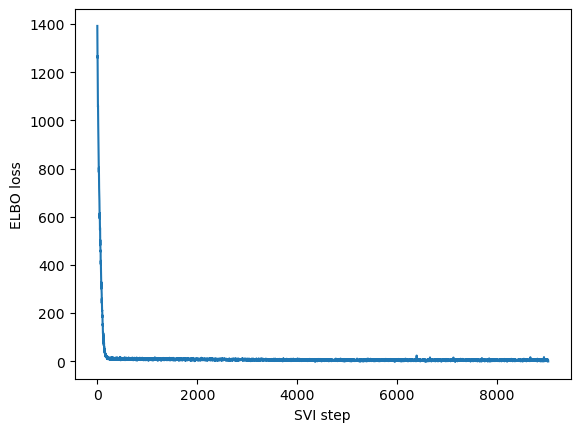

In [84]:
plt.plot(svi_losses)
plt.xlabel('SVI step')
plt.ylabel('ELBO loss')

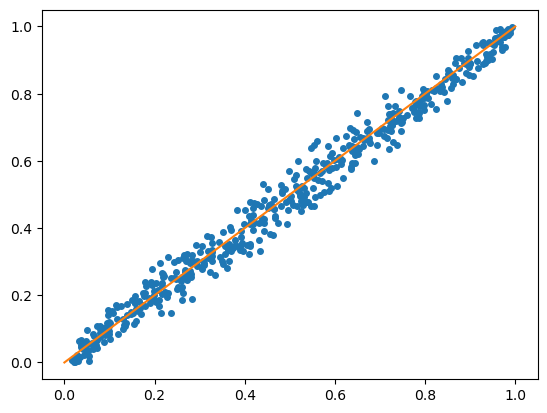

In [85]:
plt.plot(params['theta_centered'], true_centeredness, 'o', markersize=4)
plt.plot([0,1],[0,1])

In [25]:
funnel_model = reparam(funnel, config={'theta': LocScaleReparam(centered=params['theta_centered'])})

In [26]:
samples_maria, num_step = inference(funnel_model)

sample: 100%|██████████| 1000/1000 [00:00<00:00, 1147.56it/s, 31 steps of size 1.20e-01. acc. prob=0.80]


In [27]:
total_grad_steps = np.sum(np.array(num_step)) + num_svi_steps

In [28]:
samples_theta_maria = samples_maria['theta_decentered']
samples_mu_maria = samples_maria['mu']
samples_tau_maria = samples_maria['tau']

In [29]:
idata = az.convert_to_inference_data(np.expand_dims(samples_theta_maria, 0))
ess_samples = az.ess(idata)

idata_mu = az.convert_to_inference_data(np.expand_dims(samples_mu_maria, 0))
ess_samples_mu = az.ess(idata_mu)

idata_tau = az.convert_to_inference_data(np.expand_dims(samples_tau_maria, 0))
ess_samples_tau = az.ess(idata_tau)

In [30]:
ess_mu_maria = ess_samples_mu.data_vars['x'].values 
ess_data_maria = min(ess_samples.data_vars['x'].values)
ess_tau_maria = ess_samples_tau.data_vars['x'].values

In [31]:
ess_mu_maria/total_grad_steps, ess_data_maria/total_grad_steps, ess_tau_maria/total_grad_steps

(0.001333391122346259, 0.0013994024260150658, 6.071705021774101e-05)